In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset
import hashlib


In [2]:
train_concatted = pd.read_csv("/content/drive/MyDrive/ieeecis/train_concatted.csv")
num_trans_cols = pd.read_csv("/content/drive/MyDrive/ieeecis/num_trans_cols.csv", header=None).iloc[:, 0].tolist()

In [3]:
# Separate normal & fraudulent samples
X_normal = train_concatted[train_concatted['isFraud'] == 0]  # Normal transactions
X_anomaly = train_concatted[train_concatted['isFraud'] == 1]  # Fraudulent transactions (for evaluation)

print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

# Drop TransactionID and target variable from train dataset for preprocessing
# train_target = train_transaction["isFraud"]
X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
# X_normal.drop(columns=["isFraud"], inplace=True)
# X_anomaly.drop(columns=["isFraud"], inplace=True)

num_trans_cols.remove("TransactionID")

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
X_normal[num_trans_cols] = scaler.fit_transform(X_normal[num_trans_cols])
X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


# Convert data types to reduce memory usage
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
    return df

#train_df = reduce_memory(train_df)
#test_df = reduce_memory(test_df)
# Final processed datasets
print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

Train shape: (569877, 464), Test shape: (20663, 464)


<ipython-input-3-1c8cff8eda03>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
<ipython-input-3-1c8cff8eda03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
<ipython-input-3-1c8cff8eda03>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal

Train shape: (569877, 462), Test shape: (20663, 462)


<ipython-input-3-1c8cff8eda03>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test_normal = train_test_split(X_normal, test_size=0.01, random_state=42)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, z):
        h = self.relu(self.fc1(z))
        h = self.relu(self.fc2(h))
        x_rec = self.fc3(h)
        return x_rec

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)  # We'll take these features for discrimination loss.
        self.fc3 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=False)

    def forward(self, x):
        h1 = self.leaky_relu(self.fc1(x))
        h2 = self.leaky_relu(self.fc2(h1))  # Intermediate features
        logits = self.fc3(h2)
        return logits, h2




In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Example hyperparameters and settings.
input_dim =  X_normal.shape[1]         # Number of features in the dataset
latent_dim = 128
num_epochs = 50
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create synthetic normal data for illustration. Replace with your actual data.
X_normal_tensor = torch.tensor(X_normal.values.astype(np.float32), dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(X_normal_tensor, batch_size=batch_size, shuffle=False)

# Initialize models.
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Optimizers
lr_G = 1e-4
lr_D = 5e-5
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

# Loss function for GAN training.
criterion_adv = nn.BCEWithLogitsLoss()

# Labels: using conventional GAN targets:
# For real samples: 1, and for fake samples: 0.
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    total_loss_G = 0.0
    total_loss_D = 0.0
    n_batches = 0

    for i, x_batch in enumerate(train_loader):
        x_batch = x_batch.to(device)
        cur_batch = x_batch.size(0)
        n_batches += 1

        # Adversarial ground-truth labels.
        real_labels = torch.ones(cur_batch, 1, device=device)
        fake_labels = torch.zeros(cur_batch, 1, device=device)

        # ---------------------
        #  Update Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Real samples
        logits_real, _ = discriminator(x_batch)
        loss_real = criterion_adv(logits_real, real_labels)

        # Fake samples: generate from random latent noise.
        z = torch.randn(cur_batch, latent_dim, device=device)
        x_fake = generator(z).detach()  # Detach to avoid backprop into G.
        logits_fake, _ = discriminator(x_fake)
        loss_fake = criterion_adv(logits_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        #  Update Generator
        # ---------------------
        optimizer_G.zero_grad()
        z = torch.randn(cur_batch, latent_dim, device=device)
        x_fake = generator(z)
        logits_fake, _ = discriminator(x_fake)
        # Generator wants discriminator to label fake samples as real.
        loss_G = criterion_adv(logits_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        total_loss_D += loss_D.item()
        total_loss_G += loss_G.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {total_loss_D/n_batches:.4f}, Loss_G: {total_loss_G/n_batches:.4f}")

print("GAN Training Complete!")


Epoch [1/50] Loss_D: 2.3580, Loss_G: 0.6939
Epoch [2/50] Loss_D: 0.6267, Loss_G: 0.7821
Epoch [3/50] Loss_D: 0.5636, Loss_G: 0.8651
Epoch [4/50] Loss_D: 0.4977, Loss_G: 0.9653
Epoch [5/50] Loss_D: 0.4267, Loss_G: 1.0840
Epoch [6/50] Loss_D: 2.8506, Loss_G: 0.1850
Epoch [7/50] Loss_D: 1.1557, Loss_G: 1.1155
Epoch [8/50] Loss_D: 4.6179, Loss_G: 0.2907
Epoch [9/50] Loss_D: 0.6630, Loss_G: 1.3495
Epoch [10/50] Loss_D: 3.6139, Loss_G: 1.0610
Epoch [11/50] Loss_D: 2.6631, Loss_G: 0.8589
Epoch [12/50] Loss_D: 4.5768, Loss_G: 1.4888
Epoch [13/50] Loss_D: 2.6219, Loss_G: 1.1835
Epoch [14/50] Loss_D: 2.9456, Loss_G: 1.6848
Epoch [15/50] Loss_D: 3.3366, Loss_G: 1.6978
Epoch [16/50] Loss_D: 3.0686, Loss_G: 2.0067
Epoch [17/50] Loss_D: 3.0931, Loss_G: 2.2394
Epoch [18/50] Loss_D: 2.8271, Loss_G: 1.9759
Epoch [19/50] Loss_D: 2.9541, Loss_G: 2.4366
Epoch [20/50] Loss_D: 2.9201, Loss_G: 2.5113
Epoch [21/50] Loss_D: 2.8733, Loss_G: 2.7036
Epoch [22/50] Loss_D: 3.8087, Loss_G: 2.4236
Epoch [23/50] Loss_

In [7]:
def optimize_z_for_sample(x, generator, discriminator, latent_dim, num_steps=500, lr=1e-2, lambda_disc=0.1):
    """
    For a given test sample x, optimize latent vector z to minimize a combined loss.
    The loss is a weighted sum of:
      - Residual loss: || x - G(z) || (L1 loss)
      - Discrimination loss: || f(x) - f(G(z)) || (L1 or L2 on intermediate features)
    Returns the optimized z and the final loss (which is the anomaly score).
    """
    # Initialize z randomly.
    z = torch.randn(1, latent_dim, device=device, requires_grad=True)
    optimizer_z = optim.Adam([z], lr=lr)

    # Get discriminator features for x (without gradient)
    discriminator.eval()
    with torch.no_grad():
        _, feat_x = discriminator(x.unsqueeze(0))

    for step in range(num_steps):
        optimizer_z.zero_grad()
        x_rec = generator(z)
        # Residual loss (L1)
        loss_res = torch.mean(torch.abs(x - x_rec.squeeze(0)))
        # Get features for reconstructed x
        logits_rec, feat_rec = discriminator(x_rec)
        # Discrimination loss: L1 difference in features
        loss_disc = torch.mean(torch.abs(feat_x - feat_rec))
        loss = loss_res + lambda_disc * loss_disc
        loss.backward()
        optimizer_z.step()
    return z.detach(), loss.item()




In [13]:

# Randomly sample samples each from X_test_normal and X_anomaly
num_samples = 300
num_samples_an = 300
X_test_normal_sampled = X_test_normal.sample(n=num_samples, random_state=42) # Replace X_test_normal with the variable holding the normal test data
X_anomaly_sampled = X_anomaly.sample(n=num_samples_an, random_state=42)

# Create the test dataset and labels
X_test = pd.concat([X_test_normal_sampled, X_anomaly_sampled])
y_test = np.concatenate([np.zeros(num_samples, dtype=int), np.ones(num_samples_an, dtype=int)])

# # Create an index array
indices = np.arange(X_test.shape[0])

# Shuffle the index array
np.random.shuffle(indices)

# Use the shuffled indices to reorder X_test and y_test
X_test_shuffled = X_test.iloc[indices]
y_test_shuffled = y_test[indices]

# Convert to tensors
test_x_tensor = torch.tensor(X_test_shuffled.values, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(y_test_shuffled, dtype=torch.long).to(device)

# Create a TensorDataset from the tensors.
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create a DataLoader. The batch_size can be adjusted as needed.
batch_size = 32 # Example batch size; adjust as needed.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# Inference over a test set:
# Assume test_loader yields (x, label) pairs.
anomaly_scores = []
y_true = []
inference_times = []

generator.eval()
# encoder.eval()  # Not used directly in inference for AnoGAN, but may be if you combine methods.
discriminator.eval()

import time

for x, label in test_loader:  # Process one sample at a time for demonstration.
    # For AnoGAN, we optimize z for each sample separately.
    # Here we assume x is a single sample; if batch processing is needed, loop over batch.
    x = x[0].to(device)  # Use the first sample in the batch (or loop over all)
    y_true.append(label[0].item())

    start_time = time.time()
    _, score = optimize_z_for_sample(x, generator, discriminator, latent_dim,
                                     num_steps=200, lr=1e-2, lambda_disc=0.1)
    inference_times.append(time.time() - start_time)
    anomaly_scores.append(score)

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

print("Average inference time per sample: {:.4f} seconds".format(np.mean(inference_times)))
auroc = roc_auc_score(y_true, anomaly_scores)
ap = average_precision_score(y_true, anomaly_scores)
print("AUROC: {:.4f}, Average Precision: {:.4f}".format(auroc, ap))

Average inference time per sample: 0.3633 seconds
AUROC: 0.7159, Average Precision: 0.7204


In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppose these are defined from your ALAD model inference:
# y_true: true labels, e.g. np.array([...])
# anomaly_scores: continuous anomaly scores, e.g. np.array([...])

# Convert lists to numpy arrays if necessary.
y_true = np.array(y_true)
anomaly_scores = np.array(anomaly_scores)

# Option 1: Determine threshold using the 95th percentile of normal samples.
# (Assumes that normal samples are labeled 0.)
normal_scores = anomaly_scores[y_true == 0]
threshold = np.percentile(normal_scores, 90)
print("Threshold based on 95th percentile of normal samples:", threshold)

# Option 2: Or set a manual threshold (uncomment below if needed).
# threshold = 0.5

# Generate binary predictions: predict fraud (1) if score > threshold, else normal (0)
y_pred = (anomaly_scores < threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Threshold based on 95th percentile of normal samples: 1891.2947998046875
Precision: 0.3077
Recall: 0.5000
F1 Score: 0.3810


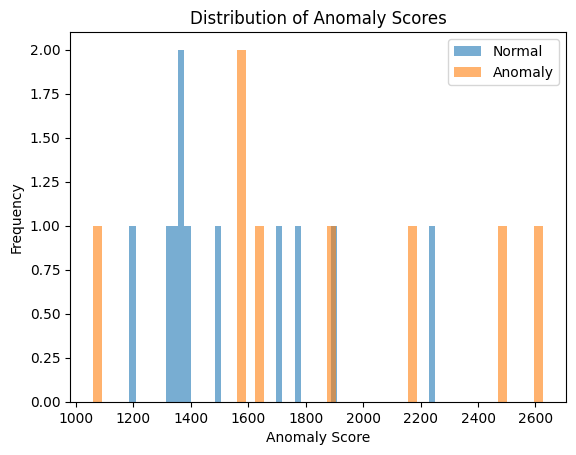

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_true and anomaly_scores are NumPy arrays
# where y_true==0 for normal and y_true==1 for anomalies.


normal_scores = anomaly_scores[y_true == 0]
anomaly_scores_only = anomaly_scores[y_true == 1]

plt.hist(normal_scores, bins=50, alpha=0.6, label='Normal')
plt.hist(anomaly_scores_only, bins=50, alpha=0.6, label='Anomaly')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.show()

AUPRC (using auc function): 0.7015
AUPRC (using average_precision_score): 0.7204


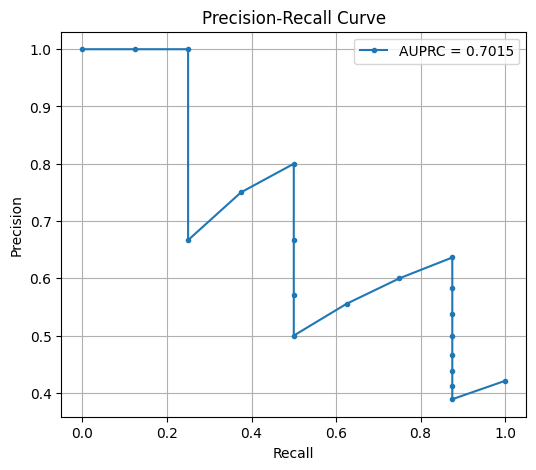

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, anomaly_scores)

# Compute AUPRC (Area Under PR Curve)
auprc = auc(recall, precision)  # Using AUC function
ap_score = average_precision_score(y_true, anomaly_scores)  # Direct AUPRC score

print(f"AUPRC (using auc function): {auprc:.4f}")
print(f"AUPRC (using average_precision_score): {ap_score:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()